# Data organizers: proof of concept
This notebook has a proof of concept with an idea for the data organization part of the plotting.

It assumes you are already familiar with the current state of ArviZ plotting, and starts showing xarray plotting functionality too, which is also a part in the inspiration for the new "data organizer".

In [1]:
import arviz as az
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [4]:
idata = az.load_arviz_data("rugby")
post = az.extract(idata)
idata.posterior["atts"]

<xarray.DataArray 'atts' (chain: 4, draw: 500, team: 6)>
array([[[ 0.106324, -0.019126, ..., -0.460838,  0.304476],
        [ 0.153829, -0.082737, ..., -0.372026,  0.226504],
        ...,
        [ 0.111329, -0.119454, ..., -0.250323,  0.221411],
        [ 0.150596, -0.0783  , ..., -0.316866,  0.157143]],

       [[ 0.247005, -0.025577, ..., -0.458475,  0.288312],
        [ 0.13158 , -0.018443, ..., -0.324822,  0.22218 ],
        ...,
        [ 0.065695, -0.024075, ..., -0.26591 ,  0.230961],
        [ 0.261962, -0.054704, ..., -0.388882,  0.268715]],

       [[ 0.139701, -0.085719, ..., -0.305878,  0.236458],
        [ 0.219363, -0.132189, ..., -0.385312,  0.223987],
        ...,
        [ 0.134559, -0.073595, ..., -0.357713,  0.235944],
        [ 0.189046, -0.063368, ..., -0.399582,  0.190714]],

       [[ 0.122362,  0.037181, ..., -0.304641,  0.130227],
        [ 0.221016, -0.083638, ..., -0.404273,  0.295298],
        ...,
        [ 0.149276, -0.062092, ..., -0.378249,  0.292327],
        [ 0.218036, -0.113943, ..., -0.291112,  0.202867]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * team     (team) object 'Wales' 'France' 'Ireland' ... 'Italy' 'England'

## current xarray plotting

xarray has a `FacetGrid` object that is the base for plotting. It allows for somewhat seaborn/pandas-like plotting style, defining which dimensions to use for facetting and for a couple asethetics. 

It is mostly also ax based like ArviZ, which is one of the patterns to avoid. I think we should integrate better with the plotting libraries and with artists (matplotlib) or glyphs (same concept in bokeh).

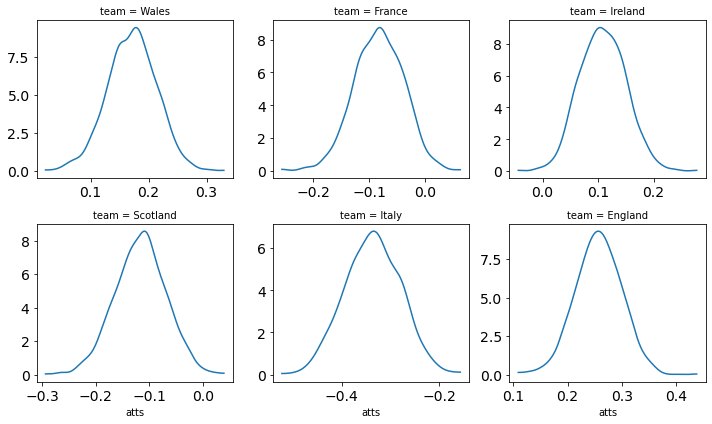

In [3]:
fg = xr.plot.FacetGrid(post, col="team", col_wrap=3, sharex=False, sharey=False)
fg.map(az.plot_dist, "atts")

plot_dist already works on the current axes if available and has no looping inside it. Therefore, it works on the provided values straight away.

We can also use this with other functions, but it is very far from ideal:

In [4]:
def plot_posterior_noax(*args, **kwargs):
    ax = plt.gca()
    az.plot_posterior(*args, ax=ax, **kwargs)

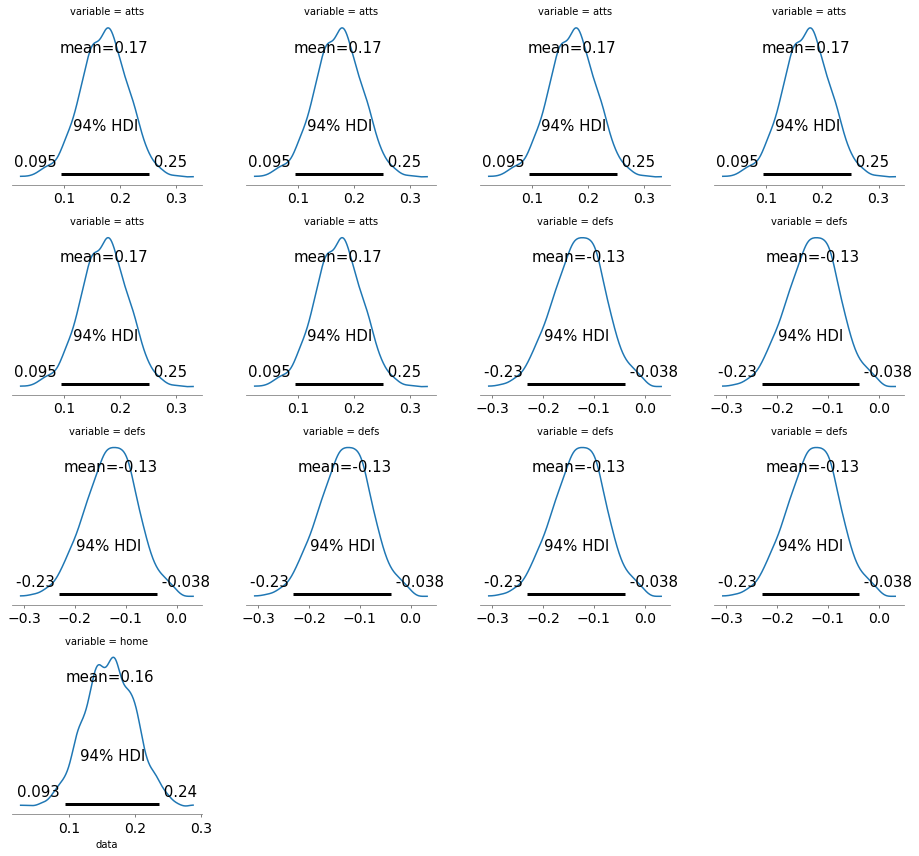

In [5]:
post = az.extract(idata, combined=False)
fg = xr.plot.FacetGrid(
    post[["atts", "defs", "home"]].to_stacked_array("param", sample_dims=["chain", "draw"], name="data").to_dataset(),
    col="variable", 
    col_wrap=4, 
    sharex=False, 
    sharey=False
)
fg.map(plot_posterior_noax, "data")

Further limitations include not being able to provide multiple dimensions as `col` in order to facet them; and the same happens with `hue` for example.

## draft proposed extensions
I propose to create a somewhat equivalent class that takes care of the data organization and making sure the right axes and aesthetics are passed together when looping to plot.

:::{important}
For now this works on `DataArray`s only!! At this point in time, this is a proof of concept we can use to discuss API and ensure I am moving in the right direction. Once we are satisfied with this, I'll work on having this work
with `Dataset`s and iterables of `Dataset` (for plotting, dataset and inferencedata are equivalent in terms of plotting, we will never want to loop over groups to plot, only have info from multiple groups).
:::

In [6]:
from arviz.plots.plot_utils import default_grid
from arviz.plots.backends.matplotlib import create_axes_grid
from arviz.sel_utils import xarray_sel_iter

from matplotlib.axes import Axes

def sel_subset(sel, present_dims):
    return {key: value for key, value in sel.items() if key in present_dims}

def subset_ds(ds, var_name, sel):
    out = ds[var_name].sel(sel_subset(sel, ds[var_name].dims))
    return out.item()

class PlotCollection:
    def __init__(
        self,
        data,
        viz_ds,
        aes=None,
        **kwargs
    ):

        self.data = data
        self.preprocessed_data = None
        self.viz = viz_ds
        self.ds = xr.Dataset()

        if aes is None:
            aes = {}

        for aes_key, dims in aes.items():
            aes_raw_shape = [len(data[dim]) for dim in dims]
            n_aes = np.prod(aes_raw_shape)
            aes_vals = kwargs.get(aes_key, [None])
            n_aes_vals = len(aes_vals)
            if n_aes_vals > n_aes:
                aes_vals = aes_vals[:n_aes]
            elif n_aes_vals < n_aes:
                aes_vals = np.tile(aes_vals, (n_aes // n_aes_vals) + 1)[:n_aes]
            self.ds[aes_key] = xr.DataArray(
                np.array(aes_vals).reshape(aes_raw_shape), 
                dims=dims,
                coords={dim: data.coords[dim] for dim in dims if dim in data.coords}
            )
        self.aes = aes
        self.base_loop_dims = set(self.viz["plot"].dims)
        
    @classmethod
    def wrap(
        cls,
        data,
        cols=None,
        col_wrap=4,
        subplot_kws=None,
        **kwargs,
    ):
        if subplot_kws is None:
            subplot_kws = {}
        plots_raw_shape = [len(data[col]) for col in cols]
        n_plots = np.prod(plots_raw_shape)
        n_rows, n_cols = default_grid(n_plots, max_cols=col_wrap)
        fig, ax_ary = create_axes_grid(n_plots, n_rows, n_cols, backend_kwargs=subplot_kws)
        plots_table_shape = ax_ary.shape
        viz_ds = xr.Dataset(
            {"chart": fig, "plot": (cols, ax_ary.flatten().reshape(plots_raw_shape))},
            coords = {col: data[col] for col in cols}
        )
        return cls(data, viz_ds, **kwargs)
    
    @classmethod
    def grid(
        cls,
        data,
        cols=None,
        rows=None,
        subplot_kws=None,
        **kwargs,
    ):
        pass
        
    def _update_aes(self, ignore_aes=frozenset()):
        aes = [aes_key for aes_key in self.aes.keys() if aes_key not in ignore_aes]
        aes_dims = [dim for sublist in list(self.aes.values()) for dim in sublist]
        all_loop_dims = self.base_loop_dims.union(aes_dims)
        return aes, all_loop_dims
    
    def plot_iterator(self, ignore_aes=frozenset()):
        aes, all_loop_dims = self._update_aes(ignore_aes)
        plotters = xarray_sel_iter(
            self.data, 
            skip_dims={dim for dim in self.data.dims if dim not in all_loop_dims}
        )
        for var_name, sel, isel in plotters:
            yield var_name, sel, isel

    def map(
        self,
        fun,
        fun_label=None,
        *,
        ignore_aes=frozenset(),
        preprocessed=False,
        subset_info=False,
        store_artist=True,
        **kwargs
    ):
        aes, all_loop_dims = self._update_aes(ignore_aes)
        plotters = xarray_sel_iter(
            self.data, 
            skip_dims={dim for dim in self.data.dims if dim not in all_loop_dims}
        )
        artist_dims = [dim for dim in self.data.dims if dim in all_loop_dims]
        artist_shape = [len(self.data[dim]) for dim in artist_dims]

        if fun_label is None:
            fun_label = fun.__name__
        
        if store_artist:
            self.viz[fun_label] = xr.DataArray(
                np.empty(artist_shape ,dtype=object), 
                dims=artist_dims,
                coords={dim: self.data[dim] for dim in artist_dims}
            )
        for var_name, sel, isel in plotters:
            da = self.data.sel(sel)
            ax = subset_ds(self.viz, "plot", sel)
                
            aes_kwargs = {}
            for aes_key in aes:
                dims = self.aes[aes_key]
                aes_kwargs[aes_key] = subset_ds(self.ds, aes_key, sel)
            
            fun_kwargs = {**kwargs, **aes_kwargs}
            if preprocessed:
                if self.preprocessed_data is None:
                    raise ValueError("You must manually set the `preprocessed_data` to use preprocessed=True")
                pre_da = self.preprocessed_data.sel(sel_subset(sel, self.preprocessed_data.dims))
                fun_kwargs["preprocessed_data"] = pre_da
            if subset_info:
                fun_kwargs = {**fun_kwargs, "var_name": var_name, "sel": sel, "isel": isel}
            aux_artist = fun(da, ax=ax, **fun_kwargs)
            if store_artist:
                self.viz[fun_label].loc[sel] = aux_artist

    def add_legend(self, aes, artist, **kwargs):
        pass

A `PlotCollection` should be initialized or reused for each plot. It can be initialized with `.grid` or `.wrap` classmethods. At init time it creates two attributes mostly: `.ds` and `.viz`.

* `.ds` is a dataset that stores the aesthetics mapping. It is used so that when we loop, we subset that dataset
  with the same `sel` used to subset the data and get the right aesthetics for that plot.
* `.viz` is used to store all the elements of the generated graph. At init time it only has the figure and axes.
  Then when plotting artists are also stored there.
  
The main method of `PlotCollection` is `.map`. `.map` loops over each of the data subsets defined in the `PlotCollection` and calls a plottting function. These plotting functions should take a dataarray of the data to plot and axes and return a single artist/glyph. It is possible to skip returning the artist, but it should be done in special cases only.

Let's see in in practice!

We start defining a function roughly equivalent to `plot_kde` but that follows the rules explained above.

In [8]:
def kde_artist(values, ax, **kwargs):
    grid, pdf = az.kde(np.array(values).flatten())
    return ax.plot(grid, pdf, **kwargs)[0]

### Base example: plot kdes for each of the 6 teams
We start with a basic example, plotting a kde for each of the teams. In this case, we only want to generate a subplot for each team, no aesthetics or anything else. We indicate this with `col=["team"]`. As we are using `.wrap` instead of row of 6 plots we get 2 rows of 3 plots.

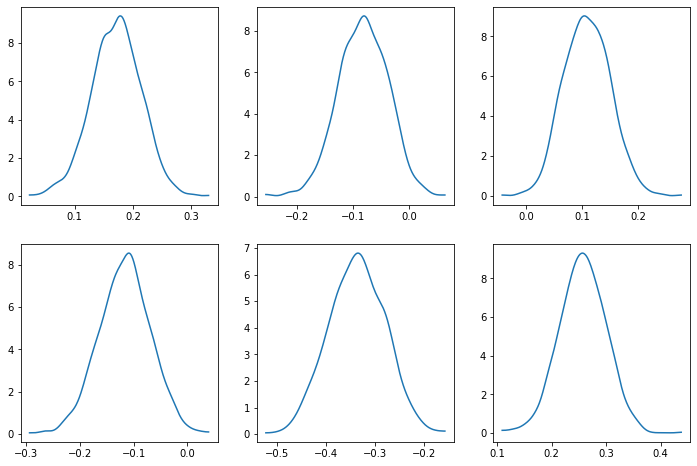

In [9]:
pc = PlotCollection.wrap(
    post["atts"], 
    cols=["team"], 
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist, "kde")

### Add aesthetics: plot kdes for each team in different subplots, overlaying the different chains with different colors.

We now use the `aes` argument to have each chain have a different color.

Note: not all plots will support all aesthetics.

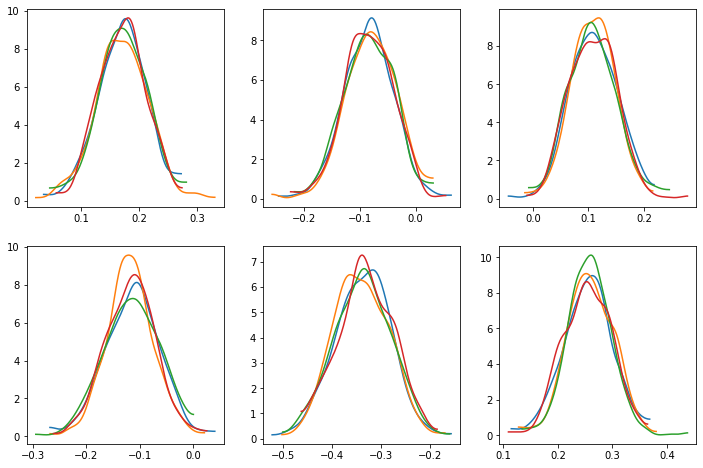

In [10]:
pc = PlotCollection.wrap(
    post["atts"], 
    cols=["team"], 
    aes={"color": ["chain"]}, 
    color=[f"C{i}" for i in range(4)],
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist, "kde")

The figure (chart), axes (plot), generated artists (name given by user) and aesthetics mappings are stored in an xarray dataset:

In [11]:
pc.viz

<xarray.Dataset>
Dimensions:  (team: 6, chain: 4)
Coordinates:
  * team     (team) object 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
  * chain    (chain) int64 0 1 2 3
Data variables:
    chart    object Figure(864x576)
    plot     (team) object AxesSubplot(0.125,0.536818;0.227941x0.343182) ... ...
    kde      (chain, team) object Line2D(_child0) ... Line2D(_child3)

### Multiple aesthetics for the same dimension

We can set multiple asethetics to the same dimension, and both will be updated in sync in all plots:

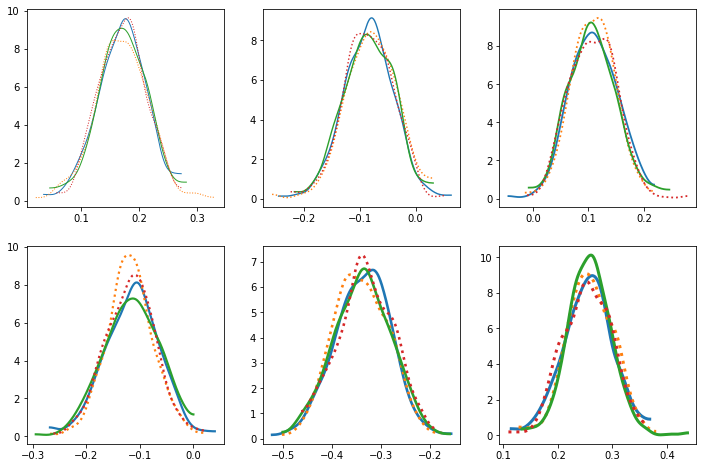

In [12]:
pc = PlotCollection.wrap(
    post["atts"], 
    cols=["team"], 
    aes={"color": ["chain"], "ls": ["chain"], "lw": ["team"]}, 
    color=[f"C{i}" for i in range(4)],
    ls=["-", ":"],
    lw=np.linspace(1, 3, 6),
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist)

### Easy access to all plots elements

And as we have stored all the plotting related data, including artists in the `.viz` attribute, we can select artists from the plot and modify them _with label based indexing_. Here we can make the line for the Italy team and 3rd chain have diamonds as markers after plotting, with size 10 and show markers only once every 50 datapoints.

Note: I'd also like to add an extra coordinate, `grid` or something of the sort, that can be used to select axes
by their position in the subplot grid.

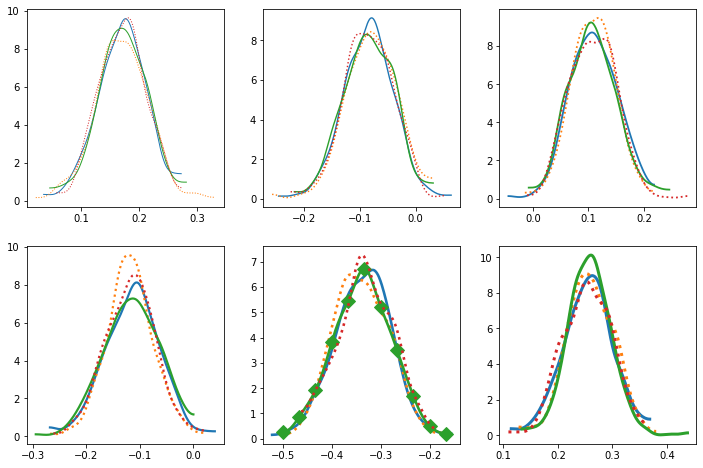

In [13]:
pc = PlotCollection.wrap(
    post["atts"], 
    cols=["team"], 
    aes={"color": ["chain"], "ls": ["chain"], "lw": ["team"]}, 
    color=[f"C{i}" for i in range(4)],
    ls=["-", ":"],
    lw=np.linspace(1, 3, 6),
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist, "kde")
pc.viz["kde"].sel(team="Italy", chain=2).item().set(marker="D", markersize=10, markevery=50);

And unlike xarray facetting, all asethetics and facetting variables take lists of dimensions, not single dimensions

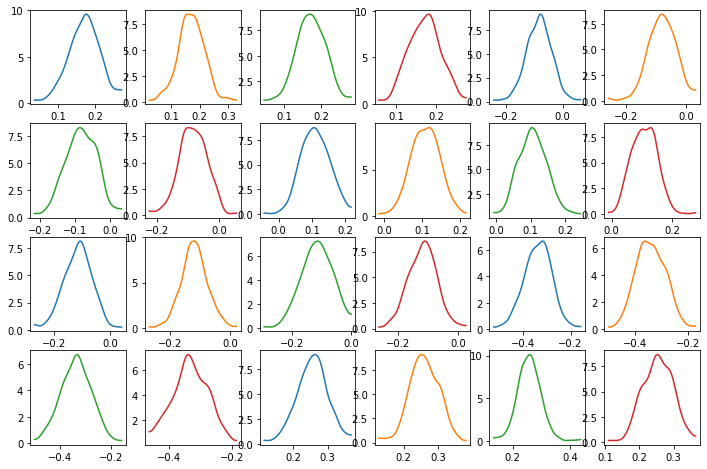

In [14]:
pc = PlotCollection.wrap(
    post["atts"], 
    cols=["team", "chain"],
    col_wrap=6,
    aes={"color": ["chain"]}, 
    color=[f"C{i}" for i in range(4)],
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist)

the `plot` variable contines to have both team and chain dimensions, that do not match the grid ones. 

In [15]:
pc.viz

<xarray.Dataset>
Dimensions:     (team: 6, chain: 4)
Coordinates:
  * team        (team) object 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
  * chain       (chain) int64 0 1 2 3
Data variables:
    chart       object Figure(864x576)
    plot        (team, chain) object AxesSubplot(0.125,0.71587;0.110714x0.164...
    kde_artist  (chain, team) object Line2D(_child0) ... Line2D(_child0)

## Mimic existing ArviZ function
We will now mimic `plot_posterior`. We start defining artist generating and returning funcitons for some more elements, like we did for kde. Functions are hidden in the rendering because they already take into account pre-processing which is explained in the next section.

In [1]:
def interval_artist(values, ax, **kwargs):
    if "preprocessed_data" in kwargs:
        pre_ds = kwargs.pop("preprocessed_data")
        interval = pre_ds["interval"]
    else:
        # not considering pre-processing would simplify the functions to these two lines
        int_func = kwargs.pop("int_func", az.hdi)
        interval = int_func(np.array(values).flatten())
    return ax.plot(interval, [0, 0], **kwargs)[0]

def point_artist(values, ax, **kwargs):
    if "preprocessed_data" in kwargs:
        pre_ds = kwargs.pop("preprocessed_data")
        point = pre_ds["point_estimate"].item()
    else:
        point_func = kwargs.pop("point_func", np.mean)
        point = point_func(np.array(values).flatten())
    return ax.plot(point, 0, **kwargs)[0]

def point_label_artist(values, ax, **kwargs):
    if "preprocessed_data" in kwargs:
        pre_ds = kwargs.pop("preprocessed_data")
        point = pre_ds["point_estimate"]
        point_label = kwargs.pop("point_label")
        pdf = pre_ds["kde"]
    else:
        point_func = kwargs.pop("point_func", np.mean)
        point_label = kwargs.pop("point_label", point_func.__name__)
        values = np.array(values).flatten()
        point = point_func(values)
        _, pdf = az.kde(values)

    top = np.max(pdf)
    
    return ax.text(point, .05 * top, f"{point:.2f} {point_label}", **kwargs)

def title_artist(values, ax, var_name, sel, isel, labeller_fun, **kwargs):
    label = labeller_fun(var_name, sel, isel)
    return ax.set_title(label, **kwargs)    

def remove_left_axis(values, ax, **kwargs):
    ax.get_yaxis().set_visible(False)
    ax.spines['left'].set_visible(False)

We now mimic plot_posterior (dataarray input only). Plot posterior takes an inferencedata and automatically generates the axes and plots everything. With `PlotCollection` this now becomes creating a plot collection (unless one is provided) and then calling `.map` multiple times to add all the elements to the plot: kde, hdi interval line, point estimate marker, point estimate text...

In [17]:
def plot_posterior(da, plot_collection=None, labeller=None):
    if plot_collection is None:
        plot_collection = PlotCollection.wrap(da, cols=[dim for dim in da.dims if dim not in {"chain", "draw"}])
    if labeller is None:
        labeller = az.labels.BaseLabeller()
        
    labeller_fun = labeller.make_label_vert
    
    plot_collection.map(kde_artist, "kde")
    plot_collection.map(interval_artist, "interval", color="grey")    
    plot_collection.map(point_artist, "point_estimate", color="C0", ms="5", marker="o")
    plot_collection.map(point_label_artist, "point_label", color="C0", va="bottom", ha="center")
    plot_collection.map(remove_left_axis, store_artist=False)
    plot_collection.map(title_artist, "title", subset_info=True, labeller_fun=labeller_fun)
    return plot_collection

Here it can be seen how the usage is the same basically as our current API, but if we also expose the artist function, it will be much easier for users to create their own variations of `plot_posterior` or to extend it with their own artist functions.

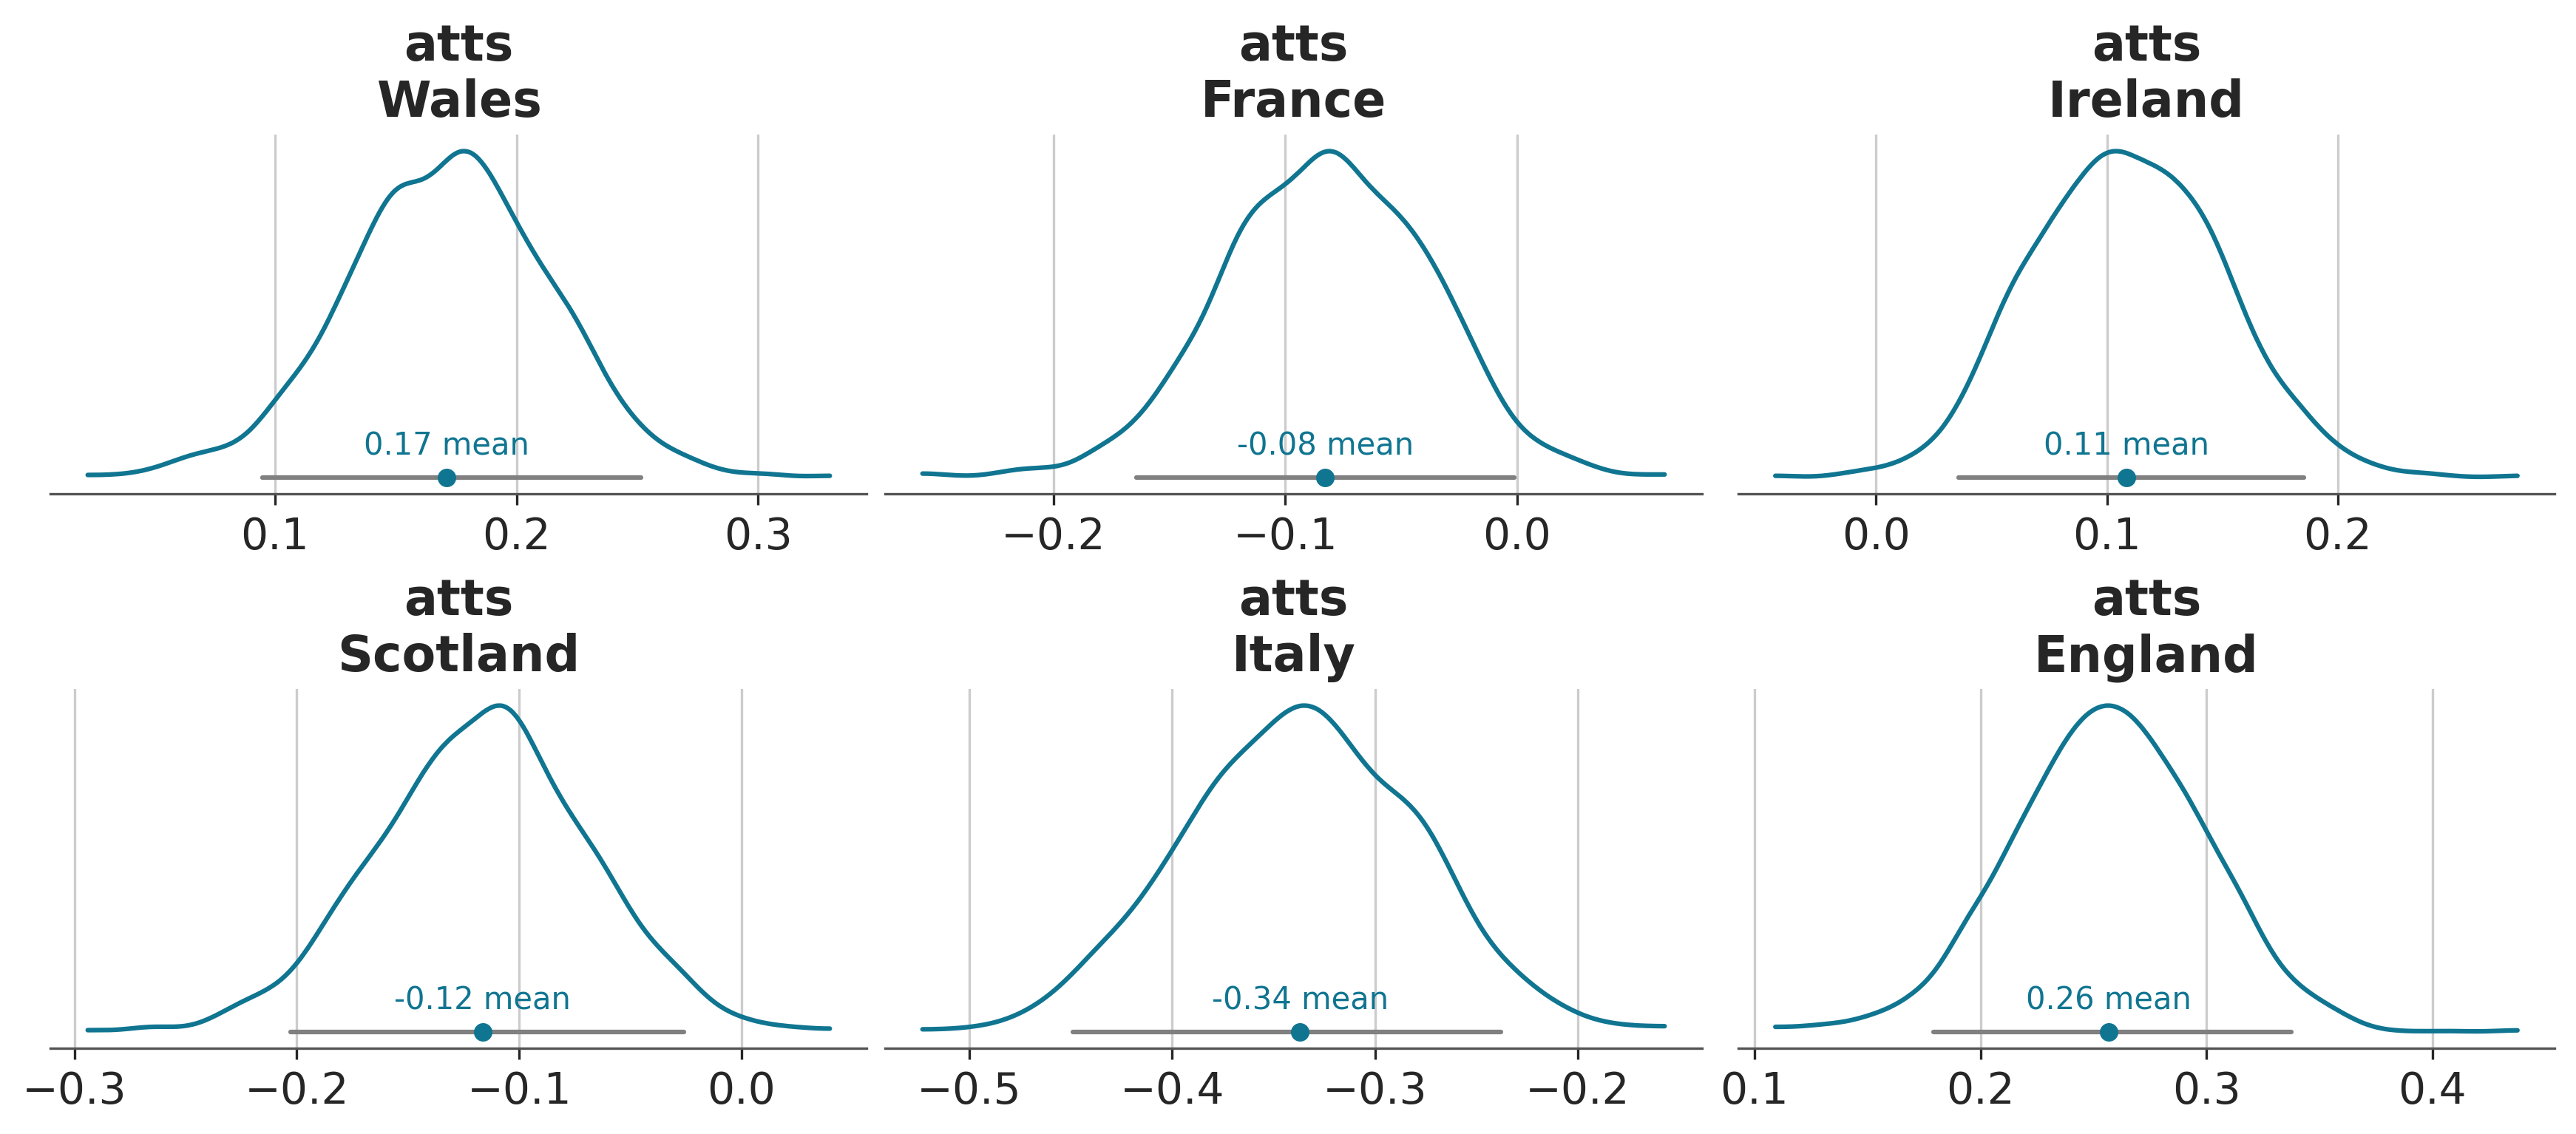

In [18]:
az.style.use("arviz-doc")
pc = plot_posterior(post["atts"])

Finally, we show how all the elements added to the plot have had their corresponding artists added to the `.viz` dataset.

In [19]:
pc.viz

<xarray.Dataset>
Dimensions:         (team: 6)
Coordinates:
  * team            (team) object 'Wales' 'France' ... 'Italy' 'England'
Data variables:
    chart           object Figure(3450x1500)
    plot            (team) object AxesSubplot(0.0147692,0.565778;0.320011x0.3...
    kde             (team) object Line2D(_child0) ... Line2D(_child0)
    interval        (team) object Line2D(_child1) ... Line2D(_child1)
    point_estimate  (team) object Line2D(_child2) ... Line2D(_child2)
    point_label     (team) object Text(0.17110852459382564, 0.470849748773512...
    title           (team) object Text(0.5, 1.0, 'atts\nWales') ... Text(0.5,...

### Use preprocessed computations
Using these independent artist functions is convenient from a plotting perspective, but computationally it is much more demanding. We need to compute the point estimate for example in both the marker and the label artist, and in fact, to make the point estimate label look nice, we place it at 0.05 the height of the kde (with the marker at 0), so we also need to compute the kde twice (or 3 times if we want to use a similar trick for the hdi label).

The overall idea was (and is) to split data organization, processing and plotting into pieces as independent as possible. (keep in mind this is only a data organization proof of concept). Here we pre compute all the quantities we will need for plot posterior, and `.map` itself is the one that subsets this preprocessed data into subsets aligned with the raw data. Thus, if we use `preprocessed=True`, in each iteration the artist function gets both the raw data and the pre-processed data properly subsetted. That is, we now compute hdi, the point estimate and the kde only once.

Note: this avenue also has a lot of potential for further speed-ups. As computing the kde is no longer done _within_ the plotting loop (as it currently happens), we can parallelize the computation using one core per team for example. Then keep the looping for the plot only.

In [20]:
# example of an artist function that only works if using preprocessed=True in .map
def kde_artist_pre(values, ax, preprocessed_data, **kwargs):
    grid = preprocessed_data["grid"]
    pdf = preprocessed_data["kde"]
    return ax.plot(grid, pdf, **kwargs)[0]
    
def plot_posterior_pre(da, plot_collection=None, labeller=None):
    if plot_collection is None:
        plot_collection = PlotCollection.wrap(da, cols=[dim for dim in da.dims if dim not in {"chain", "draw"}])
        
    # pre compute all plot elements: hdi, mean and kde and add them to plot_collection
    pre_ds = xr.Dataset()
    pre_ds["interval"] = az.hdi(da)[da.name]
    pre_ds["point_estimate"] = da.mean(("chain", "draw"))
    grid, kde = az.wrap_xarray_ufunc(
        az.kde,
        post["atts"],
        ufunc_kwargs={"n_output": 2},
        func_kwargs={"out_shape": [(512,), (512,)], "grid_len": 512},
        output_core_dims=[["x_kde"], ["x_kde"]]
    )
    pre_ds["grid"] = grid
    pre_ds["kde"] = kde
    plot_collection.preprocessed_data = pre_ds
    
    if labeller is None:
        labeller = az.labels.BaseLabeller()
    labeller_fun = labeller.make_label_vert
    
    # add all drawings to the plot with no computation inside artist functions anymore, only plotting
    plot_collection.map(kde_artist_pre, "kde", preprocessed=True)
    plot_collection.map(interval_artist, "interval", preprocessed=True, color="grey")    
    plot_collection.map(point_artist, "point_estimate", preprocessed=True, color="C0", ms="5", marker="o")
    plot_collection.map(
        point_label_artist, "point_label", preprocessed=True, point_label="mean",
        color="C0", va="bottom", ha="center"
    )
    plot_collection.map(remove_left_axis, store_artist=False)
    plot_collection.map(title_artist, "title", subset_info=True, labeller_fun=labeller_fun)
    return plot_collection

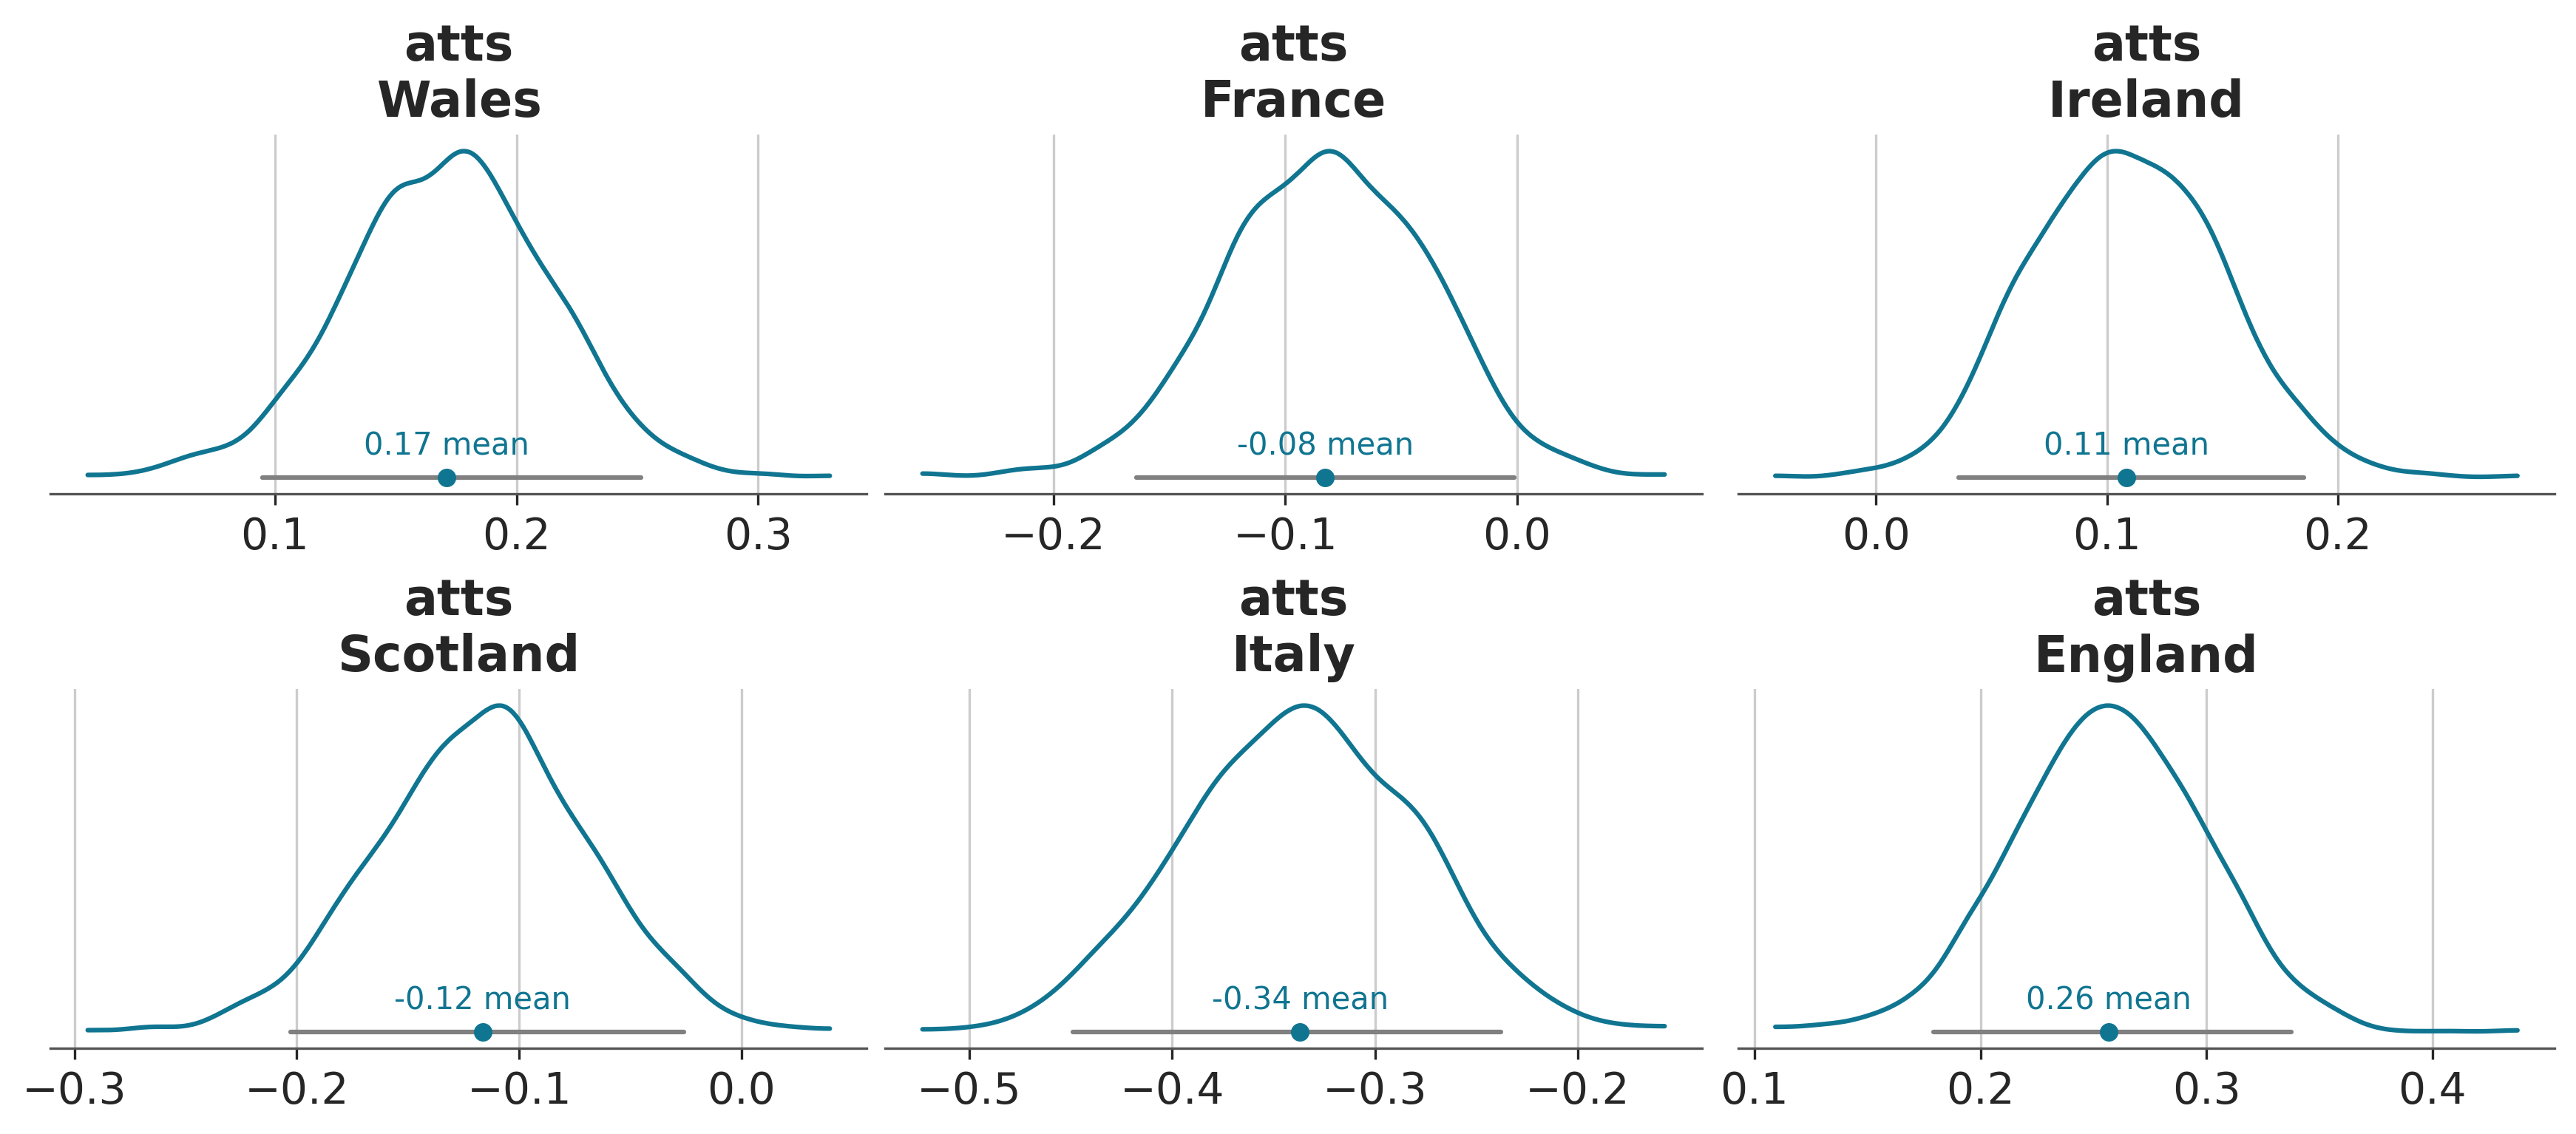

In [21]:
pc = plot_posterior_pre(post["atts"])

Pre-processed data is made available to the plot collection by setting the `.preprocessed_data` attribute which is also available later on in the returned plot collection. So potentially, all the preprocessed data could also be used in other plots (provided facetting and aesthetics are aligned!)

In [22]:
pc.preprocessed_data

<xarray.Dataset>
Dimensions:         (team: 6, hdi: 2, x_kde: 512)
Coordinates:
  * team            (team) object 'Wales' 'France' ... 'Italy' 'England'
  * hdi             (hdi) <U6 'lower' 'higher'
Dimensions without coordinates: x_kde
Data variables:
    interval        (team, hdi) float64 0.09464 0.2514 -0.1641 ... 0.1793 0.3376
    point_estimate  (team) float64 0.1711 -0.08273 0.1085 -0.1165 -0.337 0.2566
    grid            (team, x_kde) float64 0.02241 0.02301 ... 0.437 0.4376
    kde             (team, x_kde) float64 0.06984 0.07005 ... 0.04191 0.0422

Legends will come soon.